<a href="https://colab.research.google.com/github/highway92/machine_learning/blob/main/year_dream/do/roberst_scaler%EB%A5%BC_%EC%82%AC%EC%9A%A9%ED%95%9C_%EA%B8%88%EC%9C%B5%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 셋 불러오기

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

# 2. EDA

## 변수설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [3]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

training set length : 80000
validation set length : 20000


In [4]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

In [5]:
X = test_df.iloc[:, :-1]
y = test_df.iloc[:, -1]

X_test = scaler.fit_transform(X)

# Logistic Regression

In [6]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))

    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


In [7]:
def get_model_train_eval(model, X, y, X_v, y_v, threshold = 0.5):
  model.fit(X,y)
  pred = model.predict(X_v)
  pred_proba = model.predict_proba(X_v)[:, 1] >= threshold
  get_clf_eval(y_v, pred_proba)
  return (pred, pred_proba)


정확도: 0.6217
정밀도: 0.4490
재현율: 0.7511
AUC: 0.6555
F1: 0.5620


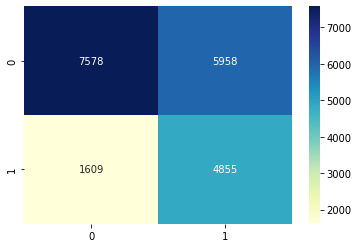

In [8]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)



정확도: 0.7109
정밀도: 0.5752
재현율: 0.4033
AUC: 0.6305
F1: 0.4742


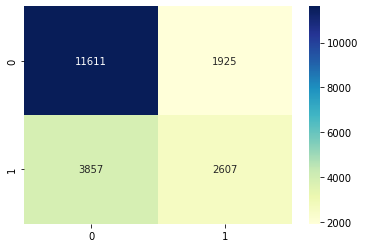

In [21]:

lr_pred = lr_clf.predict(X_valid)
lr_pred_proba = lr_clf.predict_proba(X_valid)[:, 1]>=0.45

get_clf_eval(y_valid, lr_pred_proba)


정확도: 0.7127
정밀도: 0.6129
재현율: 0.3011
AUC: 0.6051
F1: 0.4038


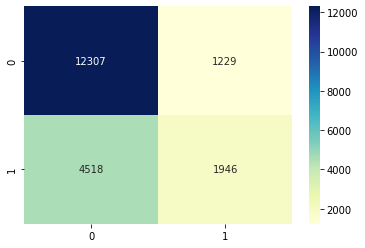

In [9]:
lr_clf = LogisticRegression()
# 파라메터 후보
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# 그리드 서치 진행
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

lr_clf = grid_search.best_estimator_
lr_pred = lr_clf.predict(X_valid)
lr_pred_proba = lr_clf.predict_proba(X_valid)[:, 1]>=0.5

get_clf_eval(y_valid, lr_pred_proba)


정확도: 0.7109
정밀도: 0.5752
재현율: 0.4033
AUC: 0.6305
F1: 0.4742


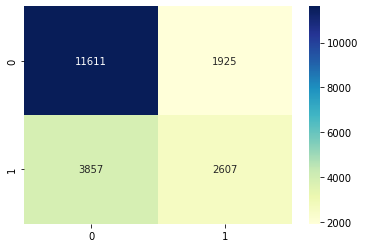

In [22]:
lr_pred_proba = lr_clf.predict_proba(X_valid)[:, 1]>=0.45

get_clf_eval(y_valid, lr_pred_proba)

In [11]:
xgb_clf = xgboost.XGBClassifier()

param_grid = {'max_depth':[3, 5, 7],
              'n_estimators':[50, 100]}

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

{'max_depth': 7, 'n_estimators': 100}


정확도: 0.7492
정밀도: 0.6125
재현율: 0.6097
AUC: 0.7128
F1: 0.6111


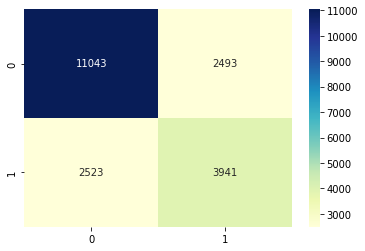

In [12]:
# best parameter를 사용하여 prediction 수행
xgb_clf = xgboost.XGBClassifier(max_depth = results.best_params_['max_depth'],
                                n_estimators = results.best_params_['n_estimators'],
                                eval_metric='mlogloss')





정확도: 0.7492
정밀도: 0.6125
재현율: 0.6097
AUC: 0.7128
F1: 0.6111


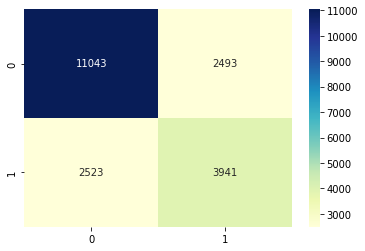

In [26]:
xgb_pred_proba = xgb_clf.predict_proba(X_valid)[:, 1]>=0.4

get_clf_eval(y_valid, xgb_pred_proba)

# Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param = {
    "min_samples_leaf" : [i for i in range(2,8)],
    "max_depth" : [i for i in range(2,7)],
}

dt_clf = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_clf, param_grid = param, cv = 3)

dt_grid.fit(X_train, y_train)

result=dt_grid.best_estimator_

result

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)

In [14]:
dt_clf = DecisionTreeClassifier(min_samples_leaf = 5,
                                max_depth = 6)

dt_clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)


정확도: 0.7143
정밀도: 0.5661
재현율: 0.4971
AUC: 0.6576
F1: 0.5293


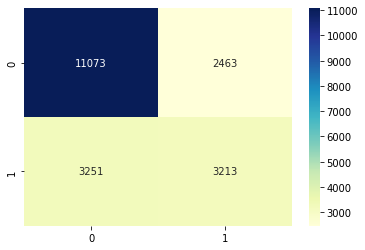

In [15]:
dt_clf_proba = dt_clf.predict_proba(X_valid)[:, 1]>=0.4
get_clf_eval(y_valid, dt_clf_proba)

In [16]:
# lgbm_clf = LGBMClassifier()
# param_grid = {
#               'num_leaves' : [20, 40, 60, 80, 100], 
#               'min_child_samples' : [5, 10, 15],
#               'max_depth' : [-1, 5, 10, 20], 
#               'learning_rate' : [0.05, 0.1, 0.2], 
#               'reg_alpha' : [0, 0.01, 0.03]
#               }
# clf = RandomizedSearchCV(lgbm_clf, param_grid, scoring = 'f1', n_iter = 100)

# clf.fit(X_train, y_train)

lgbm_clf=LGBMClassifier(max_depth = 10, min_child_samples=15, num_leaves=80, reg_alpha = 0.03)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(max_depth=10, min_child_samples=15, num_leaves=80,
               reg_alpha=0.03)


정확도: 0.7537
정밀도: 0.6588
재현율: 0.4935
AUC: 0.6857
F1: 0.5643


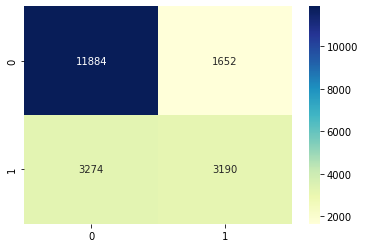

In [27]:
lgbm_pred = lgbm_clf.predict(X_valid)
lgbm_pred_proba = lgbm_clf.predict_proba(X_valid)[:, 1]>=0.5

get_clf_eval(y_valid, lgbm_pred_proba)

# Ensemble(voting) with 5 model


In [28]:
voting_clf = VotingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf),('lr', lr_clf), ('dt',dt_clf)], voting='soft')
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(max_depth=10, min_child_samples=15,
                                             num_leaves=80, reg_alpha=0.03)),
                             ('xgb',
                              XGBClassifier(eval_metric='mlogloss',
                                            max_depth=7)),
                             ('lr', LogisticRegression(C=0.001)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=6,
                                                     min_samples_leaf=5))],
                 voting='soft')


정확도: 0.7500
정밀도: 0.6877
재현율: 0.4152
AUC: 0.6626
F1: 0.5178


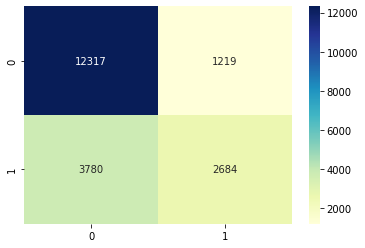

In [37]:
y_pred_vote = voting_clf.predict(X_valid)
y_pred_vote_proba = voting_clf.predict_proba(X_valid)[:, 1]>=0.5


get_clf_eval(y_valid, y_pred_vote_proba)


# Voting - with 3 model

In [30]:
voting_clf2 = VotingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf), ('dt',dt_clf)], voting='soft')
voting_clf2.fit(X_train,y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(max_depth=10, min_child_samples=15,
                                             num_leaves=80, reg_alpha=0.03)),
                             ('xgb',
                              XGBClassifier(eval_metric='mlogloss',
                                            max_depth=7)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=6,
                                                     min_samples_leaf=5))],
                 voting='soft')


정확도: 0.7548
정밀도: 0.6688
재현율: 0.4782
AUC: 0.6825
F1: 0.5576


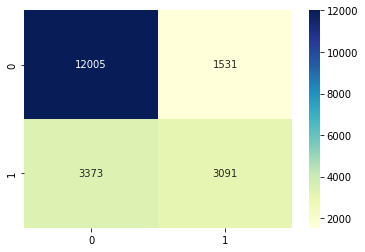

In [38]:
y_pred_vote = voting_clf2.predict(X_valid)
y_pred_vote_proba = voting_clf2.predict_proba(X_valid)[:, 1]>=0.48


get_clf_eval(y_valid, y_pred_vote_proba)


# Emsemble(Stacking) - with 5 model

In [39]:
stacking_clf = StackingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf),('lr', lr_clf), ('dt',dt_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(max_depth=10,
                                               min_child_samples=15,
                                               num_leaves=80, reg_alpha=0.03)),
                               ('xgb',
                                XGBClassifier(eval_metric='mlogloss',
                                              max_depth=7)),
                               ('lr', LogisticRegression(C=0.001)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=6,
                                                       min_samples_leaf=5))],
                   final_estimator=LGBMClassifier())


정확도: 0.7352
정밀도: 0.5715
재현율: 0.7229
AUC: 0.7320
F1: 0.6383


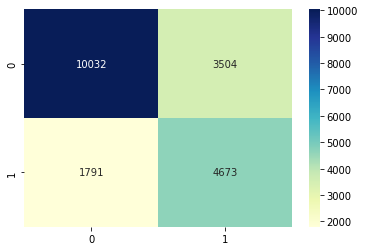

In [59]:
y_pred_stack = stacking_clf.predict(X_valid)
y_pred_stack_proba = stacking_clf.predict_proba(X_valid)[:, 1]>=0.35

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack_proba)

# Stacking with 3 model

In [41]:
stacking2_clf = StackingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf),('dt',dt_clf)], final_estimator = LGBMClassifier())
stacking2_clf.fit(X_train, y_train)


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(max_depth=10,
                                               min_child_samples=15,
                                               num_leaves=80, reg_alpha=0.03)),
                               ('xgb',
                                XGBClassifier(eval_metric='mlogloss',
                                              max_depth=7)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=6,
                                                       min_samples_leaf=5))],
                   final_estimator=LGBMClassifier())


정확도: 0.7451
정밀도: 0.5929
재현율: 0.6750
AUC: 0.7268
F1: 0.6313


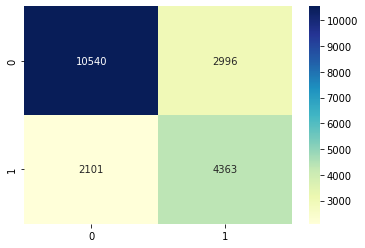

In [66]:
y_pred_stack = stacking2_clf.predict(X_valid)
y_pred_stack_proba = stacking2_clf.predict_proba(X_valid)[:, 1]>=0.4

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack_proba)

# Stacking with 2

In [43]:
stacking3_clf = StackingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking3_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(max_depth=10,
                                               min_child_samples=15,
                                               num_leaves=80, reg_alpha=0.03)),
                               ('xgb',
                                XGBClassifier(eval_metric='mlogloss',
                                              max_depth=7))],
                   final_estimator=LGBMClassifier())


정확도: 0.7441
정밀도: 0.5909
재현율: 0.6774
AUC: 0.7267
F1: 0.6312


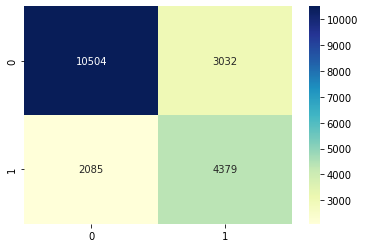

In [72]:
y_pred_stack = stacking3_clf.predict(X_valid)
y_pred_stack_proba = stacking3_clf.predict_proba(X_valid)[:, 1]>=0.4

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack_proba)

In [45]:
def submit(model, threshold = 0.5):
  temp = submission
  pred_proba = model.predict_proba(X_test)[:, 1] >= threshold
  pred_proba = pred_proba * 1
  temp['answer'] = pred_proba
  temp.to_csv('./prediction.csv', index = False)

In [73]:
submit(stacking3_clf, 0.4)